# MODELO PREDITO - FRAUDE BANCÁRIA

O objetivo desta análise preditiva é determinar se determinada transação bancária tem potencial ou não de ser uma fraude. Dessa forma, o modelo auxilia em alertas sobre transações suspeitas e que podem impedir algum tipo de dano ao cliente e ao banco em si. O objetivo desse modelo é ter uma acurácia acima de 80%.

In [1]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Carregando o dataset
base = pd.read_csv('C:/python_scripts/fraud/base.csv')

In [3]:
# Conferindo a quantidade de linhas e confirmando que a junção dos dataset está correta
print(base.shape)

(1000000, 32)


## 1. Análise Exploratória

Dataset possui 1 milhão de registros com 32 atributos. Como é um problema de classificação, é esperado que exista um desbalanceamento de classes e também possíveis atributos que estejam correlacionados. A fase de análise exploratória será excelente para identificar esses pontos e determinar quais serão os passos no pré-processamento.

In [4]:
# Visualizando os dados
base.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [5]:
# Tipos de variáveis
base.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

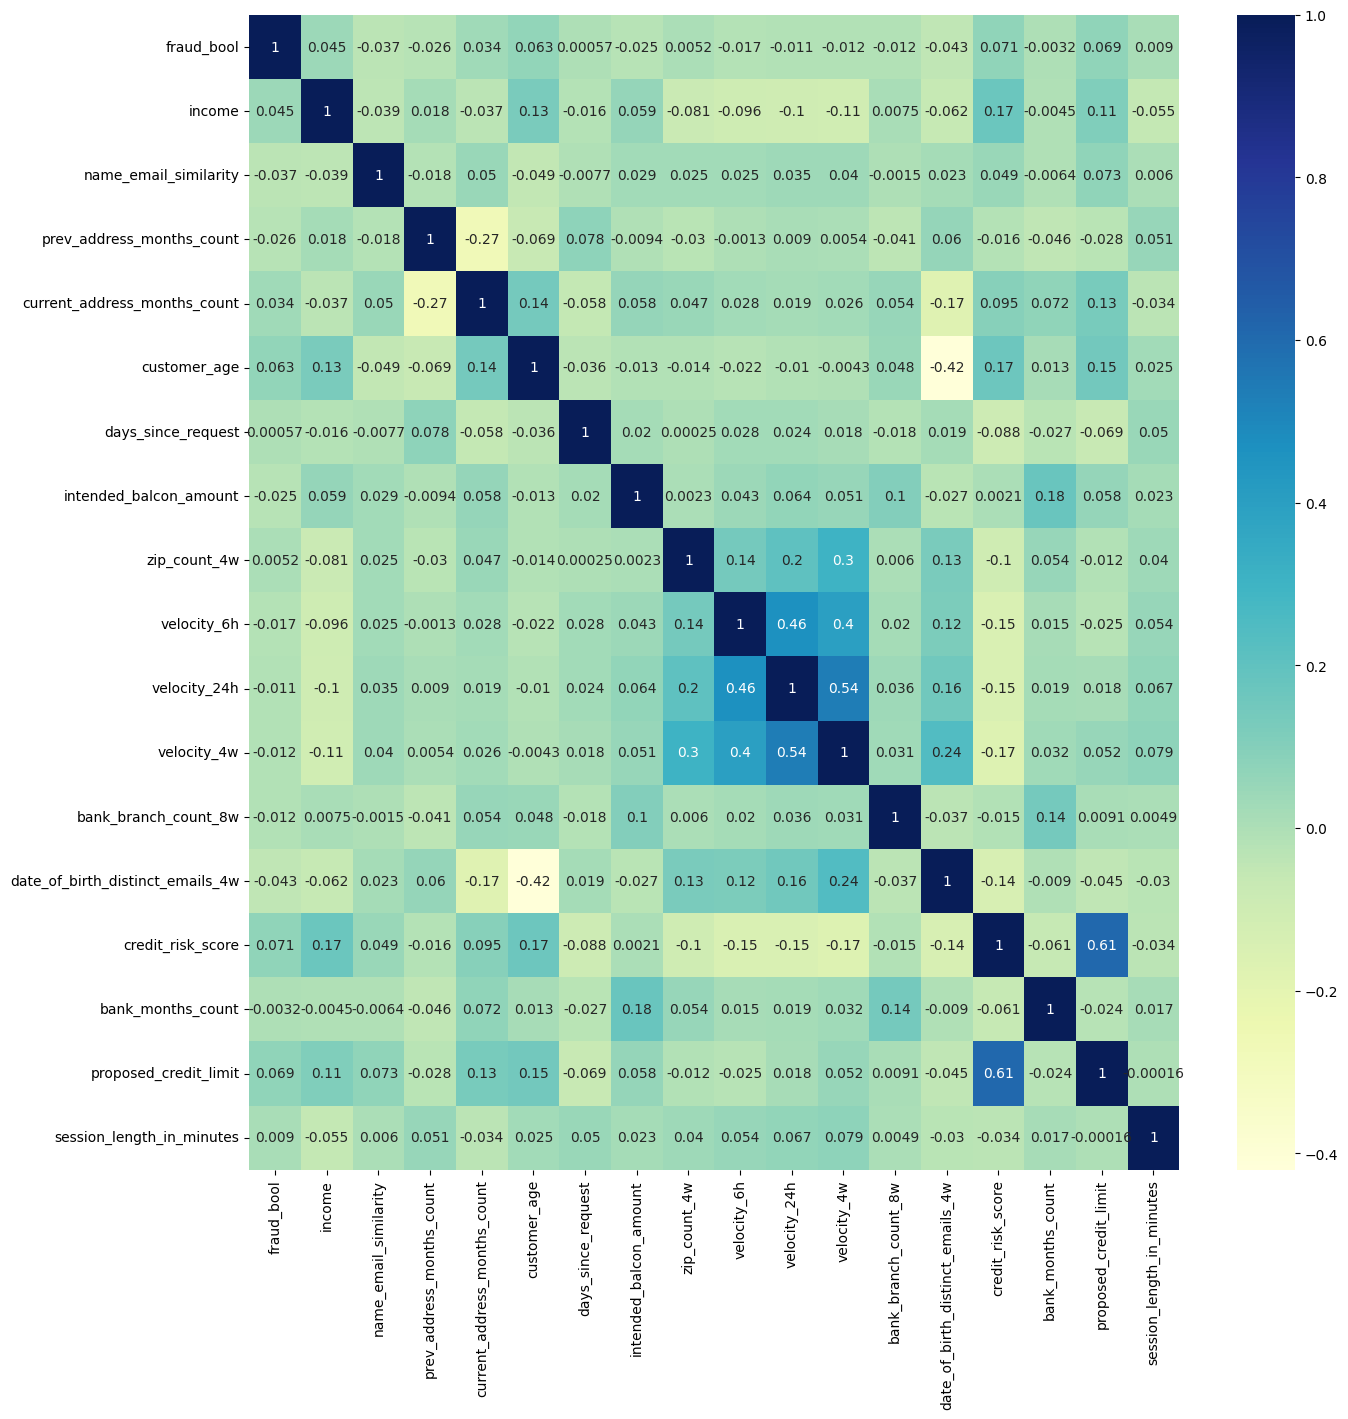

In [6]:
# Gráfico de correlação
fig, ax = plt.subplots(figsize=(15, 15))

dataplot = sns.heatmap(base[['fraud_bool','income','name_email_similarity','prev_address_months_count','current_address_months_count',
                            'customer_age','days_since_request','intended_balcon_amount','zip_count_4w', 'velocity_6h','velocity_24h',
                            'velocity_4w','bank_branch_count_8w','date_of_birth_distinct_emails_4w','credit_risk_score',
                            'bank_months_count','proposed_credit_limit','session_length_in_minutes']].corr(), 
                       cmap="YlGnBu", 
                       annot=True)

Analisando a correlação das 32 variáveis, temos algumas observações interessantes.

A primeira é que em relação a velocidade de transação de 6h, 24h e 4 sem. tem uma alta correlação entre si. Isso pode indicar que o modelo pode ficar tendecioso com o uso de todas essas variáveis. Dessa forma, é interessante testar com todas e depois com elas separadamente.

Outro ponto é que temos duas variáveis com uma alta correlação, credir_risk_score e proposed_credit_limit, e uma com baixa correlação, date_of_birth_distinct_emails_4w e  customer_age. A análise é a mesma feita no paragráfo anterior.

Text(0.5, 1.0, 'Histograma - Idade')

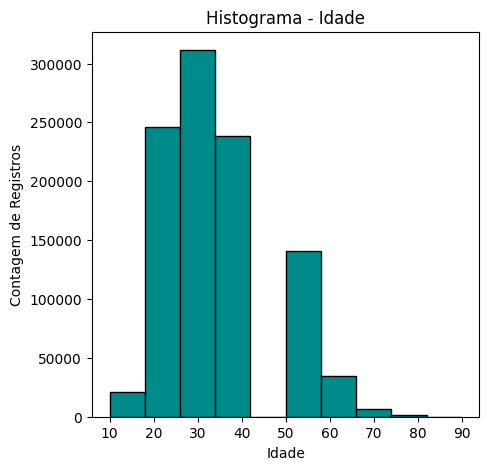

In [10]:
# Histograma da Idade

fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(base['customer_age'], color = 'darkcyan', edgecolor = 'black')
plt.ylabel('Contagem de Registros')
plt.xlabel('Idade')
plt.title('Histograma - Idade')

Pelo histograma vemos que as transações recorrentes entre 20 e 40 anos. 

Text(0.5, 1.0, 'Relação de Fraude por Idade')

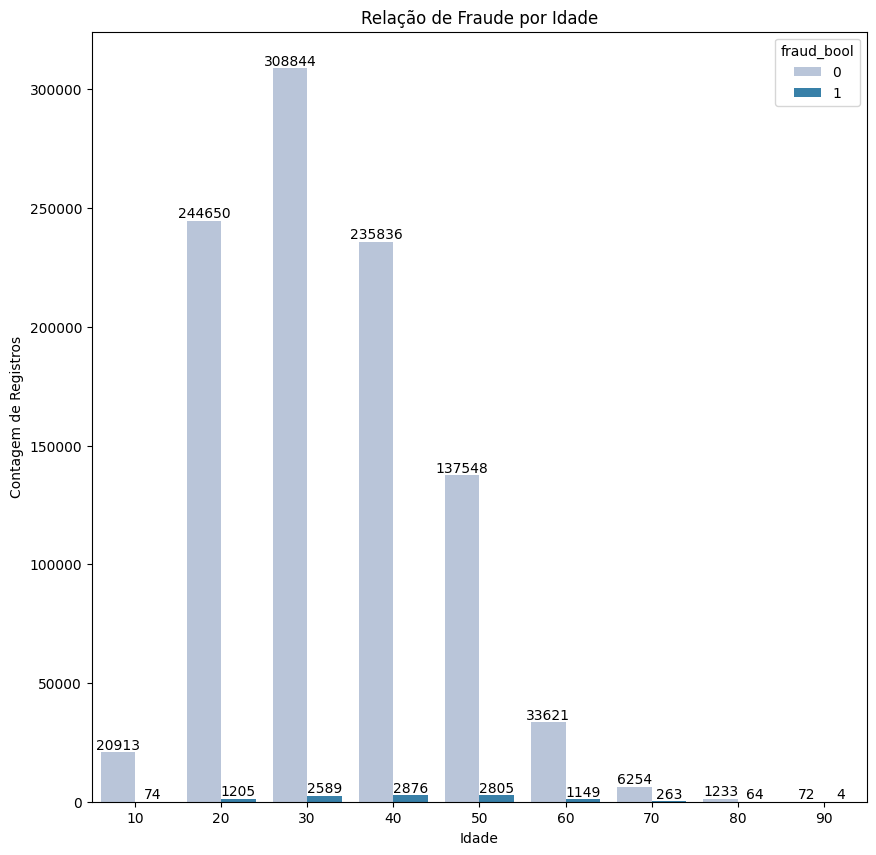

In [16]:
# Gráfico de barras fraude por idade

fig, ax = plt.subplots(figsize=(10, 10))
graf_class = sns.countplot(x = 'customer_age', 
                           data = base, 
                           palette = 'PuBu', 
                           hue = 'fraud_bool')
graf_class.bar_label(graf_class.containers[0])
graf_class.bar_label(graf_class.containers[1])
graf_class.set_xlabel('Idade')
graf_class.set_ylabel('Contagem de Registros')
graf_class.set_title('Relação de Fraude por Idade')

Neste exemplo vemos que as maiores transações fraudulentas gira em torno de idade que vão de 30 a 50 anos de idade. Os maiores volumes de transações estão entre os 20 e 30 anos. 

In [ ]:
#Bubble chart
sns.scatterplot(data = base, 
                x = "days_since_request", 
                y="bank_months_count", 
                size="credit_risk_score", 
                legend = True,
                sizes=(20,500),
                alpha=0.5,
                hue="fraud_bool")

# Coloca a legenda fora do gráfico
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# Mostra o gráfico
plt.show()

O total de registros é: 1000000
A classe 1 possui 11029 que representa 1.1 %
A classe 0 possui: 988971 que representa 98.9 %


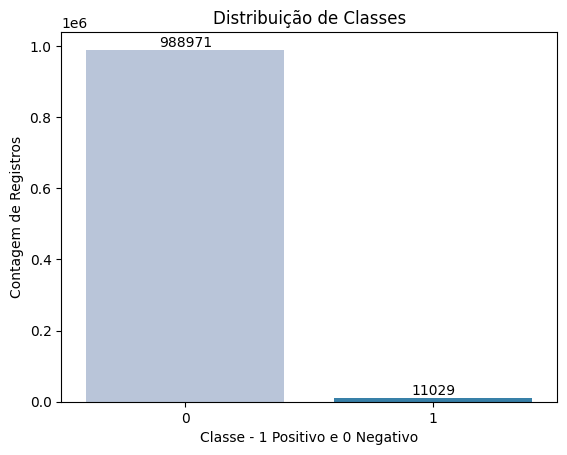

In [7]:
# Gráfico para contagem de classes na variável Frad Bool (Variável target)
graf_class = sns.countplot(x = 'fraud_bool', data = base, palette = 'PuBu')
graf_class.set_xlabel('Classe - 1 Positivo e 0 Negativo')
graf_class.set_ylabel('Contagem de Registros')
graf_class.set_title('Distribuição de Classes')

graf_class.bar_label(graf_class.containers[0])

class_table = base['fraud_bool'].value_counts()

print('O total de registros é:', class_table.sum())
print('A classe 1 possui', class_table[1].sum(), 'que representa', round((class_table[1]/class_table.sum())*100,1),"%")
print('A classe 0 possui:', class_table[0].sum(), 'que representa', round((class_table[0]/class_table.sum())*100,1),"%")

Aqui vemos que o dataset está desbalanceado, o que era esperado visto que temos muito mais transações legais do que fraudulentas no mercado. Diante disso, será necessário fazer um balanceamento de classes porque apenas 1% das transações tiveram fraude. Usar o dataset dessa forma prejudica o treinamento do modelo de machine learning.